In [1]:
def sum_weights_for_unique_masks(masks, masks_weights, logits): #, poolers):
    # Convert each boolean mask to a unique string of 0s and 1s
    mask_strs = [''.join(map(str, mask.bool().int().flatten().tolist())) for mask in masks]
    img_size = 66

    # Dictionary to store summed weights for each unique mask
    unique_masks_weights = {}
    unique_masks_logits = {}
    unique_masks_count = {}
    unique_masks_dict = {}

    for i, (mask_str, weight, pred) in enumerate(zip(mask_strs, masks_weights, logits)):
        if mask_str in unique_masks_weights:
            unique_masks_weights[mask_str] += weight
            unique_masks_logits[mask_str] += pred
            unique_masks_count[mask_str] += 1
        else:
            unique_masks_dict[mask_str] = masks[i]
            unique_masks_weights[mask_str] = weight
            unique_masks_logits[mask_str] = pred
            unique_masks_count[mask_str] = 1

    # Convert dictionary keys back to boolean masks
    unique_keys = sorted(unique_masks_weights.keys())
    unique_masks = [unique_masks_dict[key] for key in unique_keys]
    summed_weights = [unique_masks_weights[key] for key in unique_keys]
    mean_logits = [unique_masks_logits[key] for key in unique_keys]

    return unique_masks, summed_weights, mean_logits #, mean_poolers

In [2]:
class Stats:
    def __init__(self):
        self.image = None
        self.label = None
        self.unique_masks = None
        self.summed_weights = None
        self.mean_logits = None
        
        self.omega_subset = []
        self.sigma_subset = []
        self.bright_subset = []
        self.dark_subset = []
        self.highweight_subset = []
        self.darkhighweight_omega_subset = []
        self.darkhighweight_sigma_subset = []
        self.brighthighweight_omega_subset = []
        self.brighthighweight_sigma_subset = []
        self.darkgoodloss_omega_subset = []
        self.darkgoodloss_sigma_subset = []
        self.brightgoodloss_omega_subset = []
        self.brightgoodloss_sigma_subset = []
        self.stds = []
        self.mask_weight_total = {
            'dark': [0, 0],
            'bright': [0, 0]
        }
        self.mask_weight_list = {
            'dark': [[], []],
            'bright': [[], []]
        }
        
    def linearize(self):
        res_str = ''
        for k, v in self.__dict__.items():
            if k not in ['image', 'label', 'unique_masks', 'summed_weights', 'mean_logits', 'mask_intensities']:
                if isinstance(v, list) and len(v) > 0:
                    res_str += ' ' + k + ' ' + str(v)
        return res_str

In [4]:
import os
import torch
from tqdm.auto import tqdm

input_dir = '../../exps/cosmogrid_4h/best/val_results_simp'

X = []
images = []
mask_paths = []
mask_idxs = []
preds_all = []
labels_all = []
mask_id_feat_dict = {}


count = 0
filenames = sorted(os.listdir(input_dir))
stats_all = []
total = 0

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for filename in tqdm(filenames):
    try:
        data = torch.load(os.path.join(input_dir, filename), map_location=device)
    except:
        print(filename)
        continue
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = data['unique_masks']
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    stats_single = Stats()
    stats_single.image = image
    stats_single.label = label
    stats_single.unique_masks = unique_masks
    stats_single.summed_weights = summed_weights
    stats_single.mean_logits = mean_logits
    
    for i in range(len(unique_masks)):
        k = tuple([filename, i])
        img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)

        VERBOSE = False
        outputs = []


        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2

        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        # total = img_pth.numel()
        #     if i == 0: 
        #         print(bright_pixels, bright_pixels/total)
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        if VERBOSE: 
            print(f'mask #{i}')
            print(f'{frac_bright_bhuv} - fraction of bright pixels in mask / bright pixels in image')
            print(f'{frac_bright_wong} - fraction of bright pixels in mask / pixels in mask')
            print(f'Omega weight: {mask_weight[0]:.2f}, Sigma_8 weight: {mask_weight[1]:.2f}')
            print(f'[{mask_intensity:.4f} > {2*sigma:.4f}] Is supercluster? {mask_intensity > 2*sigma}')
        outputs.append([mask_intensity, 2*sigma])

        # subset for omega
        if mask_intensity > BRIGHT_THRESHOLD*sigma:
            stats_single.bright_subset.append(k)
            stats_single.mask_weight_total['bright'][0] += mask_weight[0] 
            stats_single.mask_weight_total['bright'][1] += mask_weight[1] 
            stats_single.mask_weight_list['bright'][0].append(mask_weight[0].item())
            stats_single.mask_weight_list['bright'][1].append(mask_weight[1].item())

        if mask_intensity < DARK_THRESHOLD*sigma:
            stats_single.dark_subset.append(k)
            stats_single.mask_weight_total['dark'][0] += mask_weight[0] 
            stats_single.mask_weight_total['dark'][1] += mask_weight[1] 
            stats_single.mask_weight_list['dark'][0].append(mask_weight[0].item())
            stats_single.mask_weight_list['dark'][1].append(mask_weight[1].item())


        if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[0] == 1:
            stats_single.darkhighweight_omega_subset.append(k)
        if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[1] == 1:
            stats_single.darkhighweight_sigma_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[0] >= 0.3:
            stats_single.brighthighweight_omega_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[1] >= 0.4:
            stats_single.brighthighweight_sigma_subset.append(k)

        if mask_intensity < DARK_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
            stats_single.darkgoodloss_omega_subset.append(k)
        if mask_intensity < DARK_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
            stats_single.darkgoodloss_sigma_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
            stats_single.brightgoodloss_omega_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
            stats_single.brightgoodloss_sigma_subset.append(k)
        if mask_weight[0] == 1 and (pred - label).abs().sum() < 1e-2:
            stats_single.highweight_subset.append(k)
        # subset for omega
        # print(mask_weight[0].cpu(), pred, torch.Tensor(label))
        if mask_weight[0] > 0.9 and (pred - label).abs().sum() < 1e-1: 
        #     if mask_weight[0] > 0.1 and mask_intensity > 1*sigma: 
            stats_single.omega_subset.append(k)
        if mask_weight[1] > 0.9 and (pred - label).abs().sum() < 1e-1: 
            stats_single.sigma_subset.append(k)
        stats_single.stds.append(mask_intensity / sigma)
        total += 1
        stats_str = stats_single.linearize()
        if len(stats_str) > 0 and 'dark' in stats_str and 'bright' in stats_str:
            print(stats_str)
    stats_all.append(stats_single)

  0%|          | 0/10000 [00:00<?, ?it/s]

2179.pt


In [5]:
ranges = []
for stat in stats_all:
    # print(min(stat.mask_intensities).item(), max(stat.mask_intensities).item())
    range_curr = max(stat.stds).item() - min(stat.stds).item()
    ranges.append(range_curr)

In [6]:
max(ranges)

1.7225175350904465

In [7]:
ranges.index(max(ranges))

6720

In [8]:
stats_all[ranges.index(max(ranges))].__dict__

{'image': tensor([[[-1.9815e-03, -4.5810e-03, -8.8223e-04,  ..., -3.9051e-03,
           -4.1222e-03, -6.1432e-03],
          [-5.6397e-03, -3.5639e-03, -7.6448e-04,  ..., -3.8923e-03,
           -3.4915e-03, -6.4955e-03],
          [ 3.7387e-04, -8.0370e-04, -7.6448e-04,  ..., -1.4316e-03,
           -1.8451e-03, -6.4955e-03],
          ...,
          [-6.2253e-04,  9.6552e-04, -2.0755e-03,  ..., -3.7217e-03,
           -2.1475e-03, -1.1624e-03],
          [-3.6558e-03, -3.9238e-03,  3.6269e-03,  ..., -1.4626e-03,
           -1.1745e-03, -4.5287e-04],
          [-2.5963e-03, -3.5547e-03, -1.8732e-03,  ..., -1.6713e-05,
           -4.6342e-03, -4.6342e-03]]], device='cuda:0'),
 'label': tensor([0.1409, 0.9090], device='cuda:0'),
 'unique_masks': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0

In [71]:
import math
import matplotlib.pyplot as plt

def show_img_seg_plot(image, label, unique_masks, summed_weights, mean_logits):
    rows = math.ceil(len(unique_masks)/5)
    cols = 5
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols * 3, rows * 3))
    axs = axs.ravel()
    
    for j in range(len(unique_masks)):
        img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)
        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2
        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        axs[j].imshow(image[0].cpu().numpy())
        axs[j].contour(unique_masks[j].cpu().numpy() > 0, 2, colors='red')
        # import pdb; pdb.set_trace()
        axs[j].contourf(unique_masks[j].cpu().numpy() > 0, 2, hatches=['//', None, None],
                        cmap='gray', extend='neither', linestyles='--', alpha=0.01)
        axs[j].set_title(str(round(float(mask_intensity.item() / sigma), 4)) + ' std')
        print((unique_masks[j].cpu().numpy() > 0).sum())
        print(unique_masks[j].cpu().numpy().max(), unique_masks[j].cpu().numpy().min())
    for j in range(len(axs)):
        axs[j].axis('off')
    plt.show()
    
    rows = math.ceil(len(unique_masks)/5)
    cols = 5
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols * 3, rows * 3))
    axs = axs.ravel()
    
    for j in range(len(unique_masks)):
        img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)
        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2
        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        axs[j].imshow(unique_masks[j].cpu().numpy() > 0)
        # axs[j].imshow(image[0].cpu().numpy())
        # axs[j].contour(unique_masks[j].cpu().numpy() > 0, 1, colors='red')
        # import pdb; pdb.set_trace()
        # axs[j].contourf(unique_masks[j].cpu().numpy() > 0, 1, hatches=['//', None, None],
        #                 cmap='gray', extend='neither', linestyles='--', alpha=0.01)
        # axs[j].set_title(str(round(float(mask_intensity.item() / sigma), 4)) + ' std')
    for j in range(len(axs)):
        axs[j].axis('off')
    plt.show()

387
1.0 0.0
4260
1.0 0.0


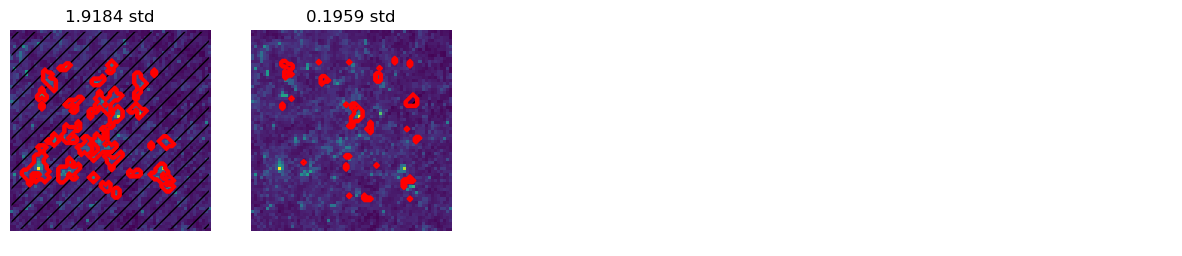

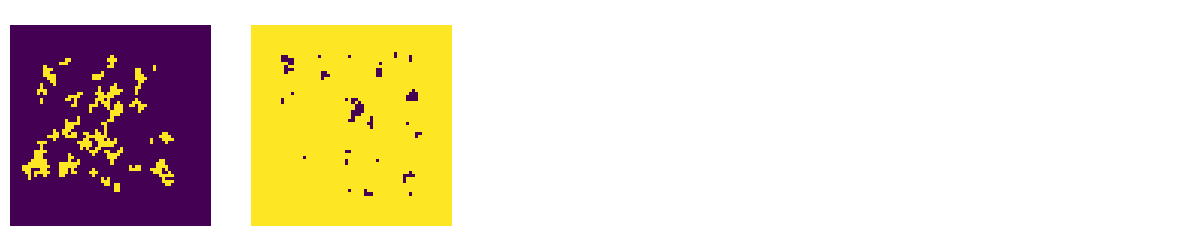

In [72]:
stat = stats_all[ranges.index(max(ranges))]
show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits)

In [16]:
stats_all[0].linearize()

" stds [tensor(0.0909, device='cuda:0')]"

In [17]:
total

41982

In [18]:
stats_all_comb = Stats()
for stat in tqdm(stats_all):
    for k, v in stat.__dict__.items():
        if k not in ['image', 'label', 'unique_masks', 'summed_weights', 'mean_logits']:
            if isinstance(v, list) and len(v) > 0:
                stats_all_comb.__dict__[k].append(v)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [26]:
len(stats_all_comb.bright_subset), stats_all_comb.bright_subset

(4,
 [[('1306.pt', 0), ('1306.pt', 1)],
  [('1595.pt', 0)],
  [('3054.pt', 0)],
  [('6369.pt', 0)]])

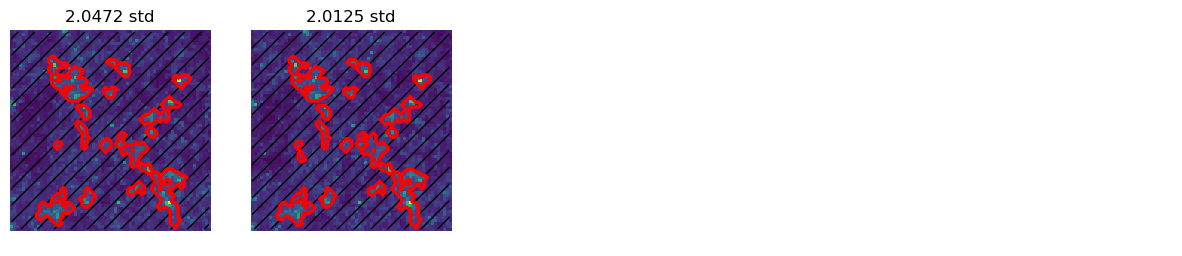

In [47]:
import matplotlib.pyplot as plt
import math

def show_img_seg(filename, i):
    data = torch.load(os.path.join(input_dir, filename))
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = data['unique_masks']
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    rows = math.ceil(len(unique_masks)/5)
    cols = 5
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols * 3, rows * 3))
    axs = axs.ravel()
    
    for j in range(len(unique_masks)):
        img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)
        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2
        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        axs[j].imshow(image[0].cpu().numpy())
        axs[j].contour(unique_masks[j].cpu().numpy() > 0, 1, colors='red')
        if (unique_masks[j].cpu().numpy() > 0).sum() < unique_masks[j].shape[-1] * unique_masks[j].shape[-2]:
            axs[j].contourf(unique_masks[j].cpu().numpy() > 0, 1, hatches=['//', None, None],
                            cmap='gray', extend='neither', linestyles='-', alpha=0.01)
        axs[j].set_title(str(round(float(mask_intensity.item() / sigma), 4)) + ' std')
    for j in range(len(axs)):
        axs[j].axis('off')
    plt.show()

filename, i = stats_all_comb.bright_subset[0][0]    
show_img_seg(filename, i)

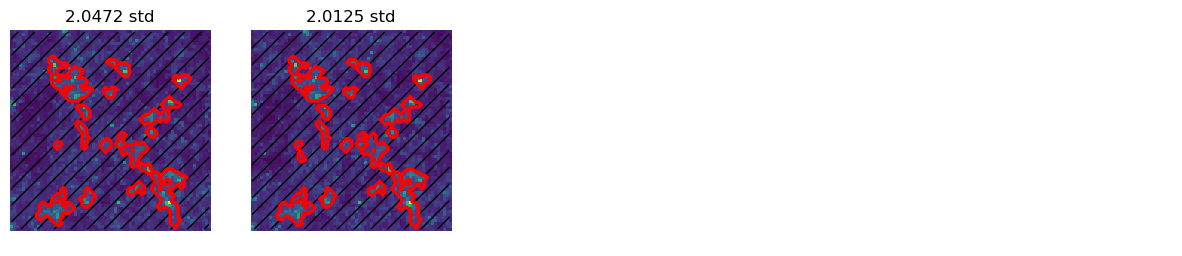

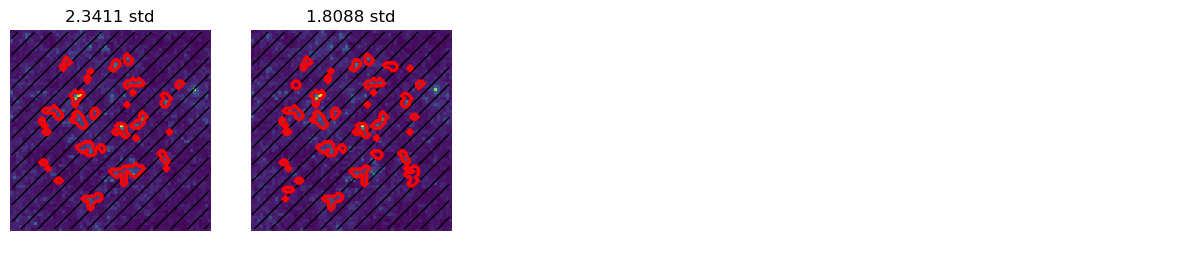

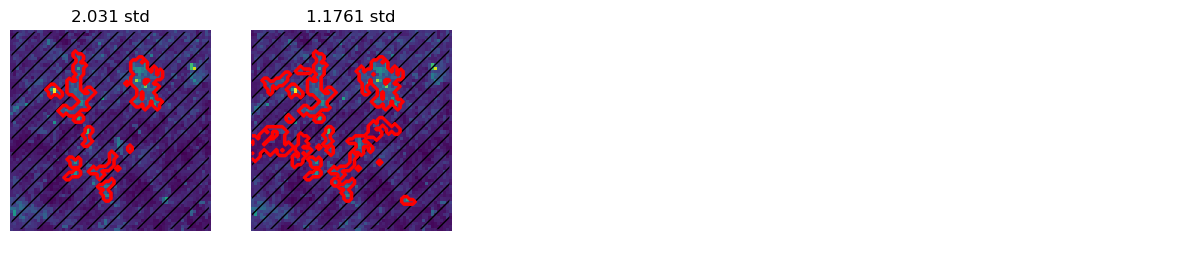

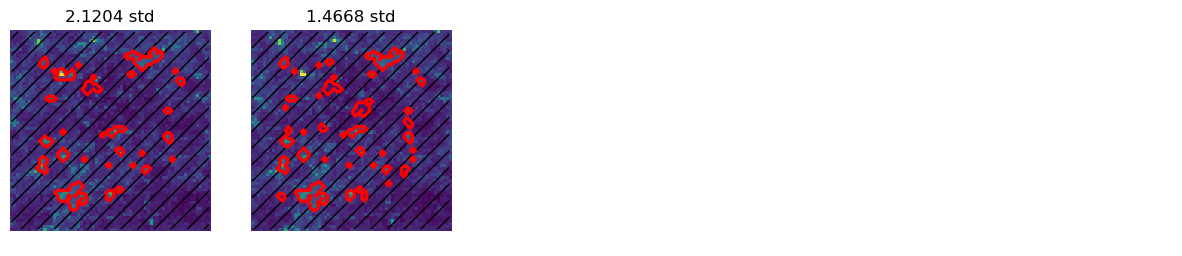

In [48]:
used = set()

for seg_list in stats_all_comb.bright_subset:
    seg_tuple = tuple(seg_list)
    if seg_tuple in used:
        continue
    used.add(seg_tuple)
    filename, i = seg_list[0]
    show_img_seg(filename, i)

In [49]:
len(stats_all_comb.dark_subset), stats_all_comb.dark_subset[:10]

(5410,
 [[('10.pt', 0), ('10.pt', 1)],
  [('1002.pt', 0)],
  [('1003.pt', 1), ('1003.pt', 6)],
  [('1005.pt', 3), ('1005.pt', 4), ('1005.pt', 5)],
  [('1006.pt', 4)],
  [('1009.pt', 0)],
  [('101.pt', 0)],
  [('1010.pt', 0)],
  [('1011.pt', 0),
   ('1011.pt', 1),
   ('1011.pt', 2),
   ('1011.pt', 3),
   ('1011.pt', 4)],
  [('1012.pt', 0), ('1012.pt', 1)]])

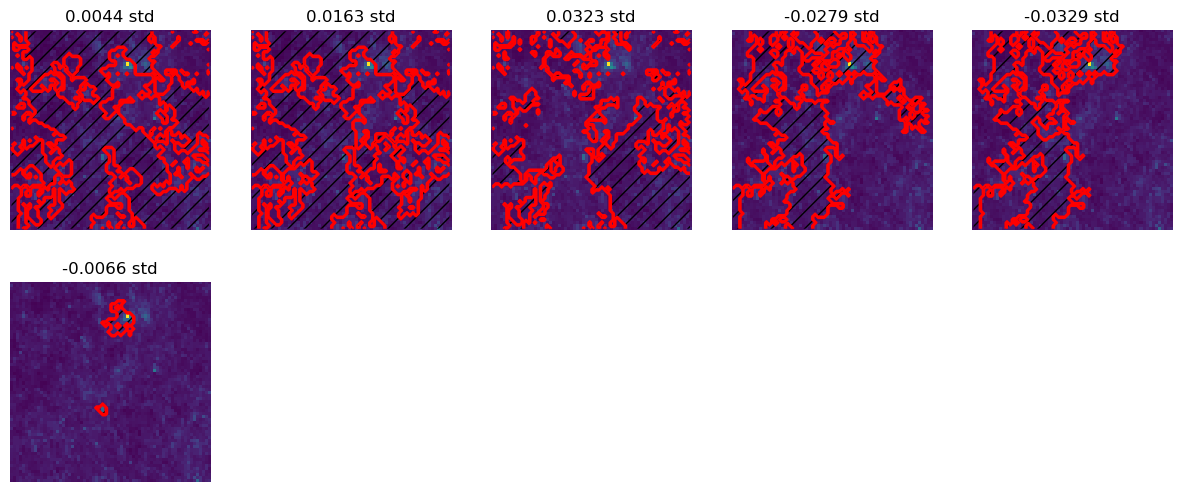

In [50]:
filename, i = stats_all_comb.dark_subset[3][0]    
show_img_seg(filename, i)

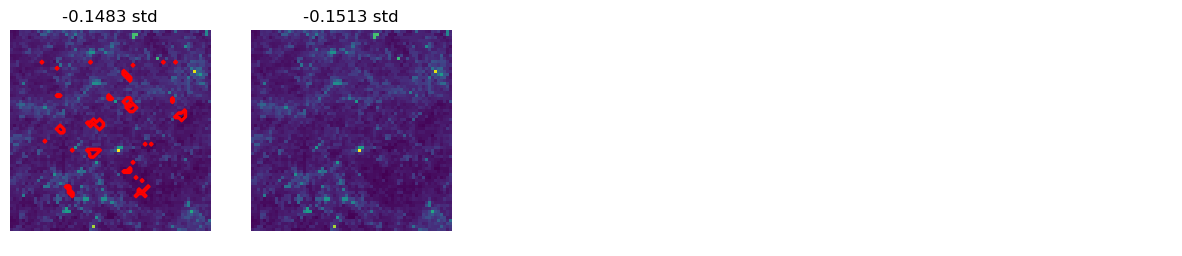

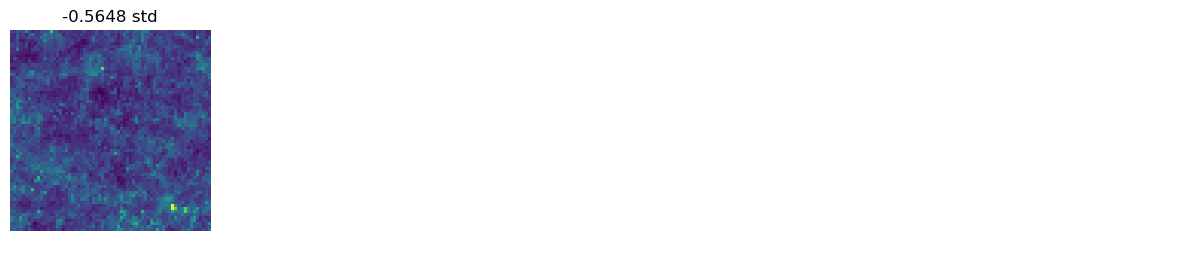

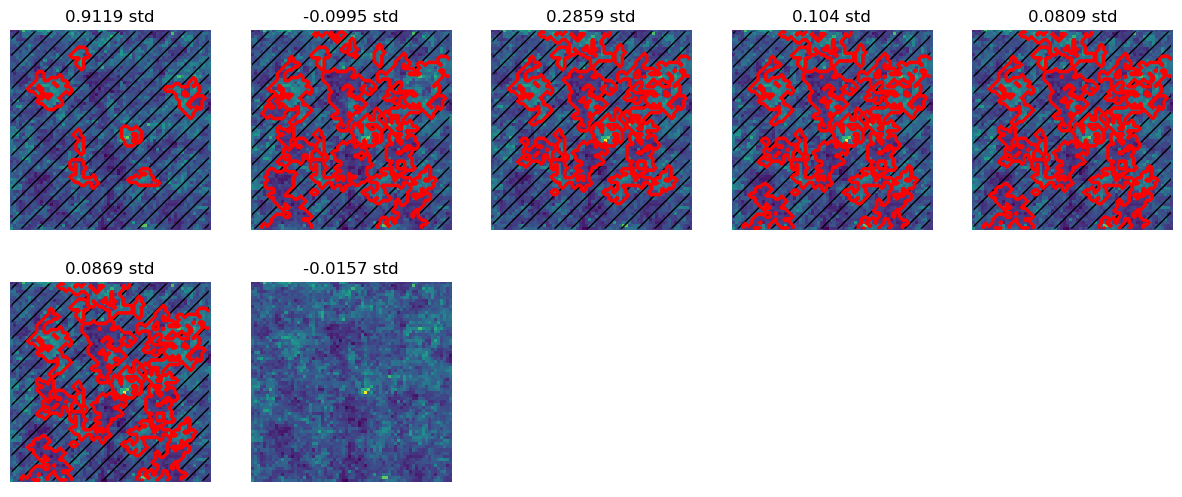

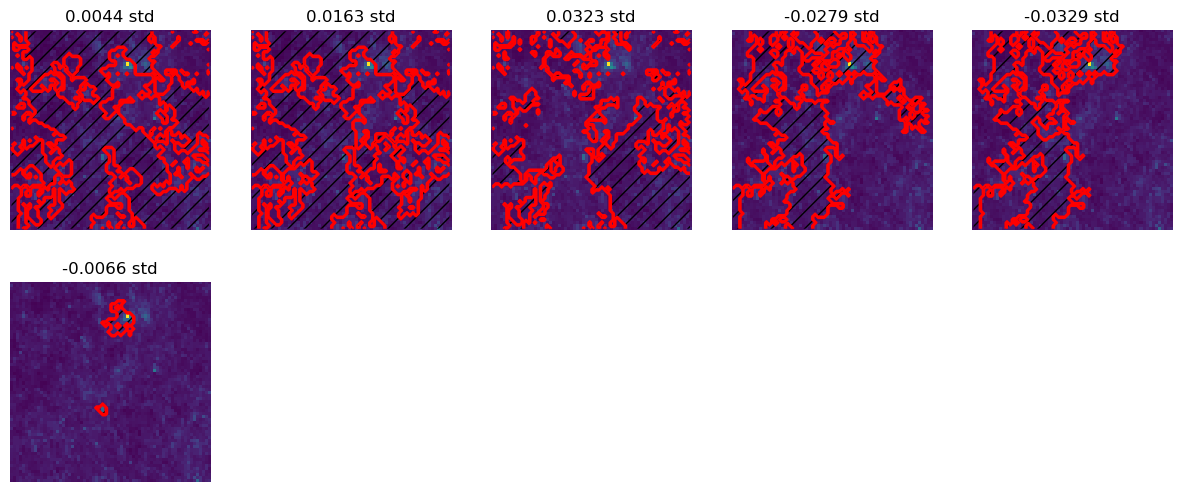

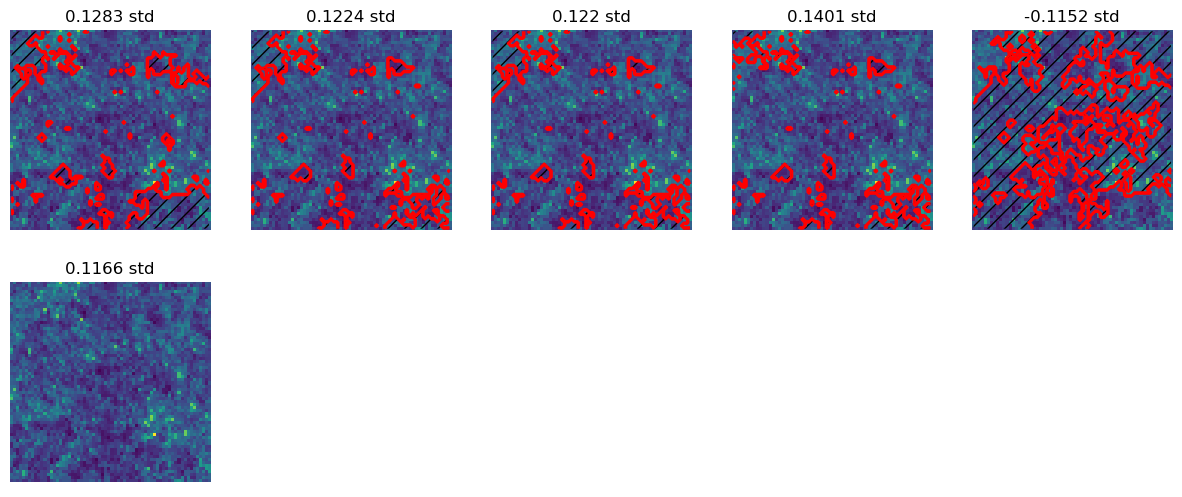

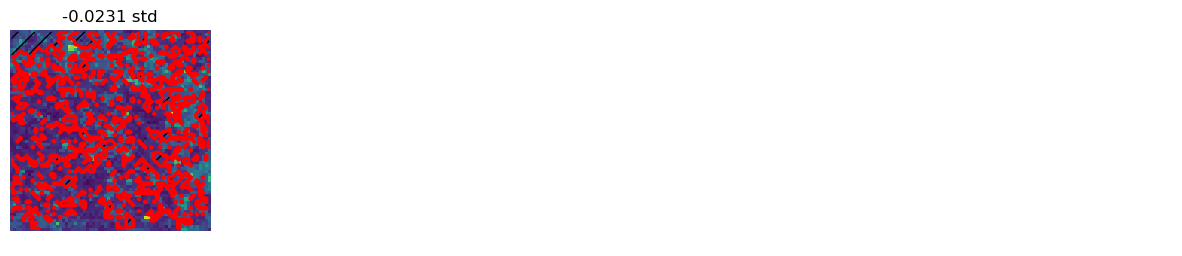

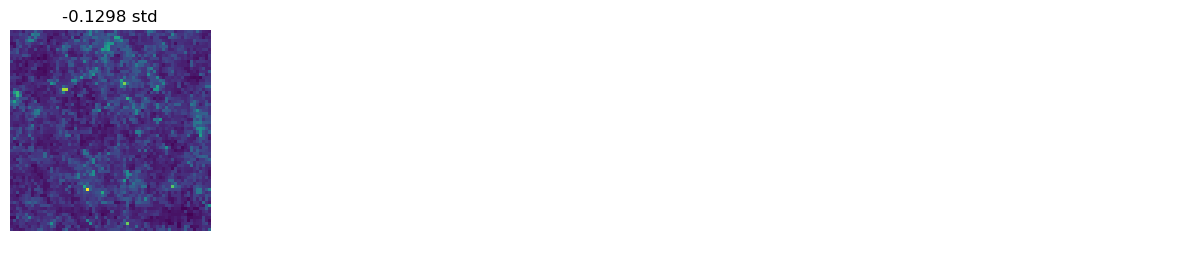

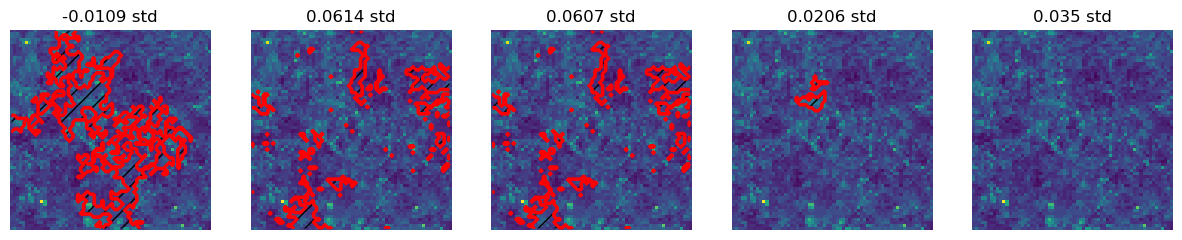

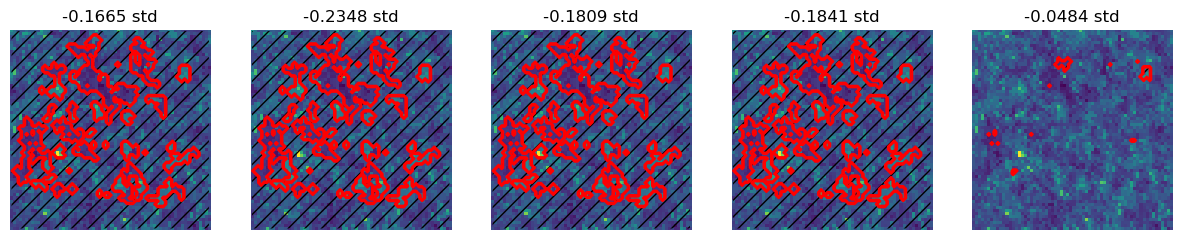

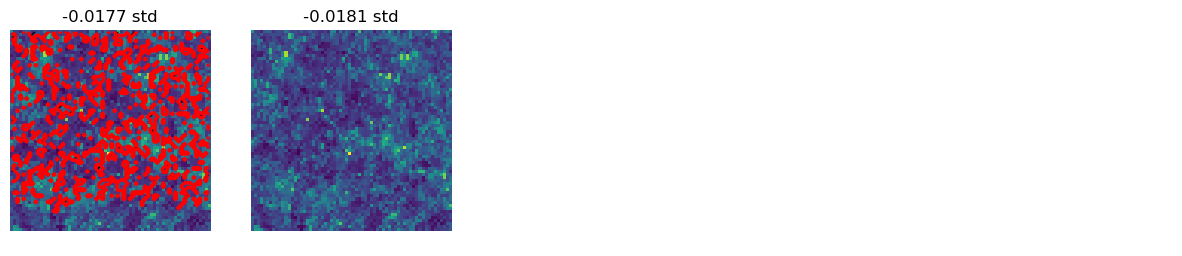

In [51]:
used = set()

for seg_list in stats_all_comb.dark_subset[:10]:
    seg_tuple = tuple(seg_list)
    if seg_tuple in used:
        continue
    used.add(seg_tuple)
    filename, i = seg_list[0]
    show_img_seg(filename, i)

In [ ]:
stats_all_comb.linearize()

## Test

In [25]:
import os
import torch
from tqdm.auto import tqdm

input_dir = '../../exps/cosmogrid_4h/best/val_results'

X = []
images = []
mask_paths = []
mask_idxs = []
preds_all = []
labels_all = []
mask_id_feat_dict = {}


count = 0
filenames = sorted(os.listdir(input_dir))
# for filename in tqdm(filenames[:1000]):
filename = filenames[100]
data = torch.load(os.path.join(input_dir, filename))


In [26]:
for k, v in data.items():
    if isinstance(v, torch.Tensor):
        print(f'{k}\t{v.shape}')
    else:
        print(f'{k}\t{v}')

image	torch.Size([1, 66, 66])
original_logits	torch.Size([2])
logits	torch.Size([2])
unique_logits_used	torch.Size([14, 2])
masks	torch.Size([800, 66, 66])
unique_masks_used	torch.Size([14, 66, 66])
unique_mask_weights_used	torch.Size([14, 2])
unique_losses_used	torch.Size([14, 2])
label	torch.Size([2])
counts	torch.Size([14])
num_labels	2


In [27]:
image = data['image']
original_logits = data['original_logits']
logits = data['logits']
unique_logits_used = data['unique_logits_used']
masks = data['masks']
unique_masks_used = data['unique_masks_used']
unique_mask_weights_used = data['unique_mask_weights_used']
unique_losses_used = data['unique_losses_used']
label = data['label']
counts = data['counts']
num_labels = data['num_labels']

In [28]:
unique_masks, summed_weights, mean_logits = sum_weights_for_unique_masks(unique_masks_used, 
                                                                        unique_mask_weights_used, 
                                                                        unique_logits_used)

In [29]:
unique_masks[0].shape, summed_weights[0].shape, mean_logits[0].shape

(torch.Size([66, 66]), torch.Size([2]), torch.Size([2]))

In [30]:
len(unique_masks), len(summed_weights), len(mean_logits)

(10, 10, 10)

In [31]:
i = 0
img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]

In [36]:
img_pth = img
mask_pth = mask #torch.from_numpy(mask)
masked_img = img_pth*(mask_pth > 1e-4)

VERBOSE = False
outputs = []

stats_single = Stats()
DARK_THRESHOLD = 0
BRIGHT_THRESHOLD = 2

sigma = img_pth.std()
bright_pixels = (img_pth > 2*sigma).sum()
total = img_pth.numel()
#     if i == 0: 
#         print(bright_pixels, bright_pixels/total)
frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
if VERBOSE: 
    print(f'mask #{i}')
    print(f'{frac_bright_bhuv} - fraction of bright pixels in mask / bright pixels in image')
    print(f'{frac_bright_wong} - fraction of bright pixels in mask / pixels in mask')
    print(f'Omega weight: {mask_weight[0]:.2f}, Sigma_8 weight: {mask_weight[1]:.2f}')
    print(f'[{mask_intensity:.4f} > {2*sigma:.4f}] Is supercluster? {mask_intensity > 2*sigma}')
outputs.append([mask_intensity, 2*sigma])



# subset for omega
if mask_intensity > BRIGHT_THRESHOLD*sigma:
    stats_single.bright_subset.append(k)
    stats_single.mask_weight_total['bright'][0] += mask_weight[0] 
    stats_single.mask_weight_total['bright'][1] += mask_weight[1] 
    stats_single.mask_weight_list['bright'][0].append(mask_weight[0].item())
    stats_single.mask_weight_list['bright'][1].append(mask_weight[1].item())

if mask_intensity < DARK_THRESHOLD*sigma:
    stats_single.vdark_subset.append(k)
    stats_single.mask_weight_total['dark'][0] += mask_weight[0] 
    stats_single.mask_weight_total['dark'][1] += mask_weight[1] 
    stats_single.mask_weight_list['dark'][0].append(mask_weight[0].item())
    stats_single.mask_weight_list['dark'][1].append(mask_weight[1].item())


if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[0] == 1:
    stats_single.darkhighweight_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[1] == 1:
    stats_single.darkhighweight_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[0] >= 0.3:
    stats_single.brighthighweight_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[1] >= 0.4:
    stats_single.brighthighweight_sigma_subset.append(k)

if mask_intensity < DARK_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
    stats_single.darkgoodloss_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
    stats_single.darkgoodloss_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
    stats_single.brightgoodloss_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
    stats_single.brightgoodloss_sigma_subset.append(k)
if mask_weight[0] == 1 and (pred - label).abs().sum() < 1e-2:
    stats_single.highweight_subset.append(k)
# subset for omega
# print(mask_weight[0].cpu(), pred, torch.Tensor(label))
if mask_weight[0] > 0.9 and (pred - label).abs().sum() < 1e-1: 
#     if mask_weight[0] > 0.1 and mask_intensity > 1*sigma: 
    stats_single.omega_subset.append(k)
if mask_weight[1] > 0.9 and (pred - label).abs().sum() < 1e-1: 
    stats_single.sigma_subset.append(k)
total += 1

sigma tensor(0.0096, device='cuda:0')
mask_intensity tensor(0.0013, device='cuda:0')


In [37]:
stats_single.__dict__

{'omega_subset': [],
 'sigma_subset': [],
 'bright_subset': ['num_labels'],
 'dark_subset': [],
 'highweight_subset': [],
 'darkhighweight_omega_subset': [],
 'darkhighweight_sigma_subset': [],
 'brighthighweight_omega_subset': [],
 'brighthighweight_sigma_subset': [],
 'darkgoodloss_omega_subset': [],
 'darkgoodloss_sigma_subset': [],
 'brightgoodloss_omega_subset': [],
 'brightgoodloss_sigma_subset': [],
 'mask_weight_total': {'dark': [0, 0],
  'bright': [tensor(0., device='cuda:0'), tensor(0.0284, device='cuda:0')]},
 'mask_weight_list': {'dark': [[], []],
  'bright': [[0.0], [0.028397947549819946]]}}

In [ ]:
# for i in range(20): 
#     v = mask_id_feat_dict[('1000.pkl',i)]

VERBOSE = False
outputs = []
omega_subset = []
sigma_subset = []
bright_subset = []
dark_subset = []
highweight_subset = []
darkhighweight_omega_subset = []
darkhighweight_sigma_subset = []
brighthighweight_omega_subset = []
brighthighweight_sigma_subset = []
darkgoodloss_omega_subset = []
darkgoodloss_sigma_subset = []
brightgoodloss_omega_subset = []
brightgoodloss_sigma_subset = []
mask_weight_total = {
    'dark': [0, 0],
    'bright': [0, 0]
}
mask_weight_list = {
    'dark': [[], []],
    'bright': [[], []]
}
DARK_THRESHOLD = 0
BRIGHT_THRESHOLD = 2

v = mask_id_feat_dict[k]
img, label, mask, mask_weight, pred = v

img_pth = torch.from_numpy(img)
mask_pth = mask.cpu() #torch.from_numpy(mask)
masked_img = img_pth*(mask_pth > 1e-4)


sigma = img_pth.std()
bright_pixels = (img_pth > 2*sigma).sum()
total = img_pth.numel()
#     if i == 0: 
#         print(bright_pixels, bright_pixels/total)
frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
if VERBOSE: 
    print(f'mask #{i}')
    print(f'{frac_bright_bhuv} - fraction of bright pixels in mask / bright pixels in image')
    print(f'{frac_bright_wong} - fraction of bright pixels in mask / pixels in mask')
    print(f'Omega weight: {mask_weight[0]:.2f}, Sigma_8 weight: {mask_weight[1]:.2f}')
    print(f'[{mask_intensity:.4f} > {2*sigma:.4f}] Is supercluster? {mask_intensity > 2*sigma}')
outputs.append([mask_intensity, 2*sigma])



# subset for omega
if mask_intensity > BRIGHT_THRESHOLD*sigma:
    bright_subset.append(k)
    mask_weight_total['bright'][0] += mask_weight[0] 
    mask_weight_total['bright'][1] += mask_weight[1] 
    mask_weight_list['bright'][0].append(mask_weight[0].cpu().item())
    mask_weight_list['bright'][1].append(mask_weight[1].cpu().item())

if mask_intensity < DARK_THRESHOLD*sigma:
    dark_subset.append(k)
    mask_weight_total['dark'][0] += mask_weight[0] 
    mask_weight_total['dark'][1] += mask_weight[1] 
    mask_weight_list['dark'][0].append(mask_weight[0].cpu().item())
    mask_weight_list['dark'][1].append(mask_weight[1].cpu().item())


if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[0].cpu() == 1:
    darkhighweight_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[1].cpu() == 1:
    darkhighweight_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[0].cpu() >= 0.3:
    brighthighweight_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[1].cpu() >= 0.4:
    brighthighweight_sigma_subset.append(k)

if mask_intensity < DARK_THRESHOLD*sigma and (pred.cpu()[0] - torch.Tensor(label)[0]).abs().sum() < 1e-2:
    darkgoodloss_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and (pred.cpu()[1] - torch.Tensor(label)[1]).abs().sum() < 1e-2:
    darkgoodloss_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred.cpu()[0] - torch.Tensor(label)[0]).abs().sum() < 1e-2:
    brightgoodloss_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred.cpu()[1] - torch.Tensor(label)[1]).abs().sum() < 1e-2:
    brightgoodloss_sigma_subset.append(k)
if mask_weight[0].cpu() == 1 and (pred.cpu() - torch.Tensor(label)).abs().sum() < 1e-2:
    highweight_subset.append(k)
# subset for omega
# print(mask_weight[0].cpu(), pred, torch.Tensor(label))
if mask_weight[0].cpu() > 0.9 and (pred.cpu() - torch.Tensor(label)).abs().sum() < 1e-1: 
#     if mask_weight[0] > 0.1 and mask_intensity > 1*sigma: 
    omega_subset.append(k)
if mask_weight[1].cpu() > 0.9 and (pred.cpu() - torch.Tensor(label)).abs().sum() < 1e-1: 
    sigma_subset.append(k)
total += 1
#     plotter(masked_img)
#     plt.show()
    